# Project One

### Author：

In [13]:
!pip install wbdata

## 1A Population Statistics

In [47]:
import wbdata
import pandas as pd

INDICATORS = {
    "SP.POP.TOTL": "total",
    "SP.POP.0014.TO.ZS": "age_0_14_pct",
    "SP.POP.1564.TO.ZS": "age_15_64_pct",
    "SP.POP.65UP.TO.ZS": "age_65_up_pct",
    "SP.POP.TOTL.MA.ZS": "male_pct",
    "SP.POP.TOTL.FE.ZS": "female_pct",
}

def split_age_share(age_range):
    fine_low, fine_high = age_range
    coarse_bins = [(0,14), (15,64), (65,100)]
    weights = {}

    for c_low, c_high in coarse_bins:
        overlap_low = max(fine_low, c_low)
        overlap_high = min(fine_high, c_high)
        if overlap_low <= overlap_high:
            overlap = overlap_high - overlap_low + 1
            total = c_high - c_low + 1
            weights[(c_low, c_high)] = overlap / total

    return weights


def population(year, sex, age_range, place):

    df = wbdata.get_dataframe(INDICATORS, country=place)
    df.index = pd.to_datetime(df.index).year
    df = df.sort_index()

    if df.empty or year not in df.index:
        raise ValueError(f"No data for place={place}, year={year}")

    row = df.loc[year]
    total = float(row["total"])

    # sex share
    s = str(sex).lower()
    if s in ["people", "all", "total"]:
        sex_share = 1.0
    elif s in ["male", "males", "man", "men"]:
        sex_share = float(row["male_pct"]) / 100.0
    elif s in ["female", "females", "woman", "women"]:
        sex_share = float(row["female_pct"]) / 100.0
    else:
        raise ValueError("sex must be people/male/female")

    # age share (supports arbitrary ranges)
    if age_range == (0,100):
        age_share = 1.0
    else:
        weights = split_age_share(age_range)
        age_share = 0
        for (c_low, c_high), w in weights.items():
            if (c_low, c_high) == (0,14):
                age_share += w * float(row["age_0_14_pct"]) / 100
            elif (c_low, c_high) == (15,64):
                age_share += w * float(row["age_15_64_pct"]) / 100
            elif (c_low, c_high) == (65,100):
                age_share += w * float(row["age_65_up_pct"]) / 100

    return total * sex_share * age_share


## 2A Unit Test

In [48]:
# 2A Unit Tests

# A2-1: basic sanity: total world population should be in billions
t_wld = population(2000, "people", (0,100), "WLD")
assert t_wld > 5e9, "World population in 2000 should be > 5 billion"

# A2-2: male+female should be close to total
m_wld = population(2000, "male", (0,100), "WLD")
f_wld = population(2000, "female", (0,100), "WLD")
assert abs((m_wld + f_wld) - t_wld) / t_wld < 0.03, "Male+Female should be close to total"

# A2-3: male share should be around 50% (very safe band)
assert 0.45 < m_wld / t_wld < 0.55, "Male share should be around 50%"

# A2-4 (NEW): your custom age bins should add up close to total
bins = [(0,10), (11,20), (21,30), (31,40), (41,50), (51,100)]
sum_bins = sum(population(2000, "people", b, "WLD") for b in bins)
assert abs(sum_bins - t_wld) / t_wld < 0.10, "Custom age bins should sum close to total"

## 3A Population Dataframe

In [51]:
def population_dataframe(places, years):
    """
    Return a DataFrame indexed by (place, year).
    Columns are population counts for age-sex groups (3 age bins x 2 sexes).
    """
    rows = []
    for p in places:
        for y in years:
            rows.append({
                "place": p,
                "year": y,
                "Male_0_10": population(y, "male", (0,10), p),
                "Male_11_20": population(y, "male", (11,20), p),
                "Male_21_30": population(y, "male", (21,30), p),
                "Male_31_40": population(y, "male", (31,40), p),
                "Male_41_50": population(y, "male", (41,50), p),
                "Male_51_100": population(y, "male", (51,100), p),
                "Female_0_10": population(y, "female", (0,10), p),
                "Female_11_20": population(y, "female", (11,20), p),
                "Female_21_30": population(y, "female", (21,30), p),
                "Female_31_40": population(y, "female", (31,40), p),
                "Female_41_50": population(y, "female", (41,50), p),
                "Female_51_100": population(y, "female", (51,100), p),
            })
    return pd.DataFrame(rows).set_index(["place", "year"]).sort_index()

In [53]:
df = population_dataframe(
    places=["KHM"],
    years=range(1970, 1990)
)
df.head()

Male_0_10     Male_11_20     Male_21_30     Male_31_40  \
place year                                                              
KHM   1970  1.080796e+06  602927.844989  349851.722880  349851.722880   
      1971  1.088014e+06  601036.419240  342324.963544  342324.963544   
      1972  1.095284e+06  603476.883023  341986.439284  341986.439284   
      1973  1.100003e+06  606218.065352  343694.987128  343694.987128   
      1974  1.096548e+06  606010.895013  345443.455588  345443.455588   

               Male_41_50    Male_51_100   Female_0_10   Female_11_20  \
place year                                                              
KHM   1970  349851.722880  588510.755403  1.079365e+06  602129.577591   
      1971  342324.963544  579469.727066  1.097882e+06  606487.794093   
      1972  341986.439284  580476.995632  1.116324e+06  615069.521603   
      1973  343694.987128  584347.529462  1.131933e+06  623815.003396   
      1974  345443.455588  588259.478657  1.139044e+06  629496.544987   

             Female_21_30   Female_31_40   Female_41_50  Female_51_100  
place year                                                              
KHM   1970  349388.524460  349388.524460  349388.524460  587731.576014  
      1971  345429.836456  345429.836456  345429.836456  584725.492934  
      1972  348555.912451  348555.912451  348555.912451  591627.812181  
      1973  353671.561137  353671.561137  353671.561137  601309.622577  
      1974  358830.944412  358830.944412  358830.944412  611057.181343

## B Population Pyramids

In [54]:
def plot_population_pyramid(df, place, year):
    year_df = df.loc[(place, year)]

    age_groups = ["0–10", "11–20", "21–30", "31–40", "41–50", "51+"]

    male_counts = [
        -year_df["Male_0_10"],
        -year_df["Male_11_20"],
        -year_df["Male_21_30"],
        -year_df["Male_31_40"],
        -year_df["Male_41_50"],
        -year_df["Male_51_100"],
    ]

    female_counts = [
        year_df["Female_0_10"],
        year_df["Female_11_20"],
        year_df["Female_21_30"],
        year_df["Female_31_40"],
        year_df["Female_41_50"],
        year_df["Female_51_100"],
    ]

    layout = go.Layout(
        barmode="overlay",
        title=f"Population Pyramid for {place} ({year})",
        yaxis=go.layout.YAxis(title="Age Group"),
        xaxis=go.layout.XAxis(title="Number"),
        bargap=0.15
    )

    bins = [
        go.Bar(
            x=male_counts,
            y=age_groups,
            orientation="h",
            name="Men",
            marker=dict(color="purple"),
            hoverinfo="skip"
        ),
        go.Bar(
            x=female_counts,
            y=age_groups,
            orientation="h",
            name="Women",
            marker=dict(color="pink"),
            hoverinfo="skip"
        )
    ]

    py.iplot(dict(data=bins, layout=layout))

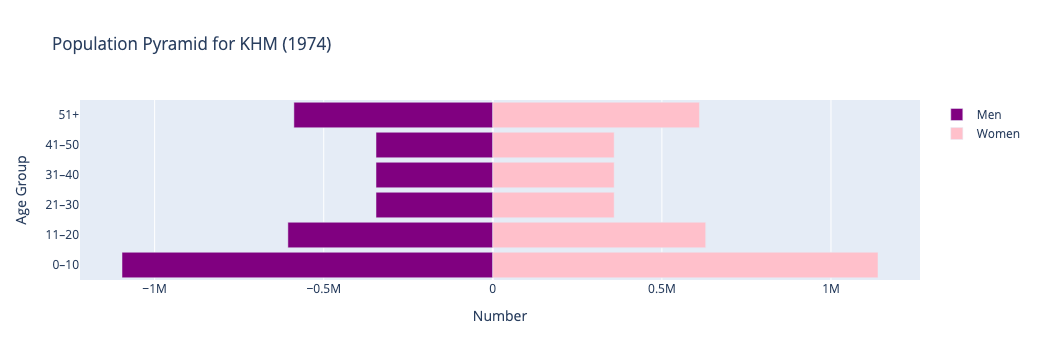

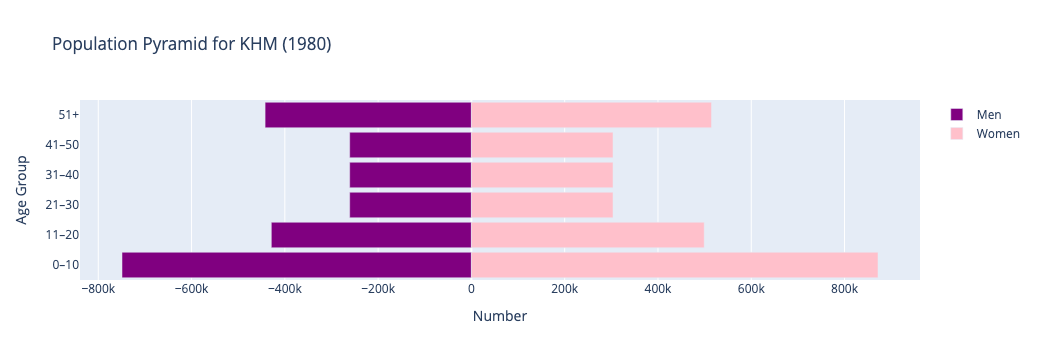

In [55]:
plot_population_pyramid(df, "KHM", 1974)
plot_population_pyramid(df, "KHM", 1980)
